In [1]:
# Load data

In [1]:
import numpy as np

fast_model_fast_data = np.load("nighttime_ai_fast_model_fast_data_activations.npy")
fast_model_slow_data = np.load("nighttime_ai_fast_model_slow_data_activations.npy")
slow_model_slow_data = np.load("nighttime_ai_slow_model_slow_data_activations.npy")
slow_model_fast_data = np.load("nighttime_ai_slow_model_fast_data_activations.npy")

[d.shape for d in (fast_model_fast_data, fast_model_slow_data, slow_model_slow_data, slow_model_fast_data)]

[(19250, 256), (20304, 256), (20304, 256), (19250, 256)]

In [3]:
# Find N for Kmeans

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

d = dict()


def f(name, data, name_kmeans):
    inertias = {}
    for n in range(2, 10):
        t0 = time.time()
        model = KMeans(n_clusters=n, random_state=0).fit(data)
        inertia = model.inertia_
        print(
            f'Getting kmeans with {n} clusters for {name} dataset took {time.time() - t0} seconds. Inertia is {inertia}.')
        inertias[n] = inertia
    name_kmeans[name] = inertias


f('fast_model_fast_data', fast_model_fast_data, d)
f('fast_model_slow_data', fast_model_slow_data, d)
f('slow_model_fast_data', slow_model_fast_data, d)
f('slow_model_slow_data', slow_model_slow_data, d)
d

Getting kmeans with 2 clusters for fast_model_fast_data dataset took 0.4014160633087158 seconds. Inertia is 706000.6734387488.
Getting kmeans with 3 clusters for fast_model_fast_data dataset took 0.4556572437286377 seconds. Inertia is 643626.2081278247.
Getting kmeans with 4 clusters for fast_model_fast_data dataset took 0.5788619518280029 seconds. Inertia is 590755.6585162741.
Getting kmeans with 5 clusters for fast_model_fast_data dataset took 0.7003631591796875 seconds. Inertia is 537179.360932007.
Getting kmeans with 6 clusters for fast_model_fast_data dataset took 0.6505641937255859 seconds. Inertia is 486165.4933320271.
Getting kmeans with 7 clusters for fast_model_fast_data dataset took 0.8455960750579834 seconds. Inertia is 451912.9842237651.
Getting kmeans with 8 clusters for fast_model_fast_data dataset took 0.7557482719421387 seconds. Inertia is 406405.98202567996.
Getting kmeans with 9 clusters for fast_model_fast_data dataset took 0.7570037841796875 seconds. Inertia is 377

{'fast_model_fast_data': {2: 706000.6734387488,
  3: 643626.2081278247,
  4: 590755.6585162741,
  5: 537179.360932007,
  6: 486165.4933320271,
  7: 451912.9842237651,
  8: 406405.98202567996,
  9: 377727.1888688636},
 'fast_model_slow_data': {2: 426732.60426765773,
  3: 310114.508472314,
  4: 234827.46010090114,
  5: 204188.27632092676,
  6: 175433.4210965248,
  7: 154475.3348290607,
  8: 143182.5337736251,
  9: 133025.0009478526},
 'slow_model_fast_data': {2: 262966.2089589669,
  3: 201076.9929443689,
  4: 172964.82951241356,
  5: 152451.21239528988,
  6: 139998.05405584382,
  7: 131132.9971818972,
  8: 122607.94636912647,
  9: 115422.54511075263},
 'slow_model_slow_data': {2: 918867.3595885925,
  3: 830132.5798754117,
  4: 765439.3431139563,
  5: 697115.3116521599,
  6: 644799.423506899,
  7: 584551.9750577608,
  8: 523594.78361474373,
  9: 476704.97096726374}}

65621.4617103936
27843.42405951348
20290.949789510305
85018.83980276232


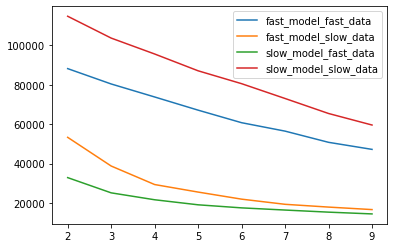

In [5]:

for name, data in d.items():
    data = {k: v for k, v in data.items()}
    average_inertia_over_samples = np.array(list(data.values())) / len(data.values())
    plt.plot(data.keys(), average_inertia_over_samples, label=name)
    print(average_inertia_over_samples.mean())
plt.legend()

In [6]:
# Clustering with N=4

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

train = fast_model_fast_data[:9500, :]
test = fast_model_fast_data[9500:9500 + 9500, :]
train.shape, test.shape

((9500, 256), (9500, 256))

In [6]:
# Compare train & test inertias

In [7]:
model = KMeans(n_clusters=4, random_state=0)
train_labels = model.fit_predict(train)


def inertia(model, labels, data):
    return np.square(model.cluster_centers_[labels] - data).sum()


# test my inertia function
train_inertia = inertia(model, train_labels, train)
model.inertia_, train_inertia


(296204.9600912921, 296204.960091292)

In [8]:
test_labels = model.predict(test)

inertia(model, test_labels, test)

291263.3807886219

In [9]:
# Expecting OOD data inertia to be bigger

In [45]:
ood_data = fast_model_slow_data[9500:9500 + 9500]
ood_labels = model.predict(ood_data)
inertia(model, ood_labels, ood_data)


523914.17726544413

In [46]:
ood_data = fast_model_slow_data[:9500]
ood_labels = model.predict(ood_data)
inertia(model, ood_labels, ood_data)


527237.683631413

In [47]:
import pandas as pd

df = pd.DataFrame(np.array([train_labels, test_labels, ood_labels]).T, columns=['train', 'test', 'ood'])

df['train'].value_counts()

1    7325
2     796
3     691
0     688
Name: train, dtype: int64

In [48]:
df['test'].value_counts()


1    7194
2     930
0     747
3     629
Name: test, dtype: int64

In [49]:
df['ood'].value_counts()


1    9497
3       3
Name: ood, dtype: int64

In [15]:
# How much do clusters match ground truth angle classes?

In [16]:
fast_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')[
          :, 2]

train_gt = fast_gt[:9500]
test_gt = fast_gt[9500:9500 + 9500]
fast_gt.shape, train_gt.shape, test_gt.shape

((19250,), (9500,), (9500,))

In [17]:
slow_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/open-loop-results/nighttime-slow-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')[
          :, 2]

train_gt = slow_gt[:9500]
test_gt = slow_gt[9500:9500 + 9500]
slow_gt.shape, train_gt.shape, test_gt.shape

((20304,), (9500,), (9500,))

Text(0.5, 1.0, 'slow data angles histogram')

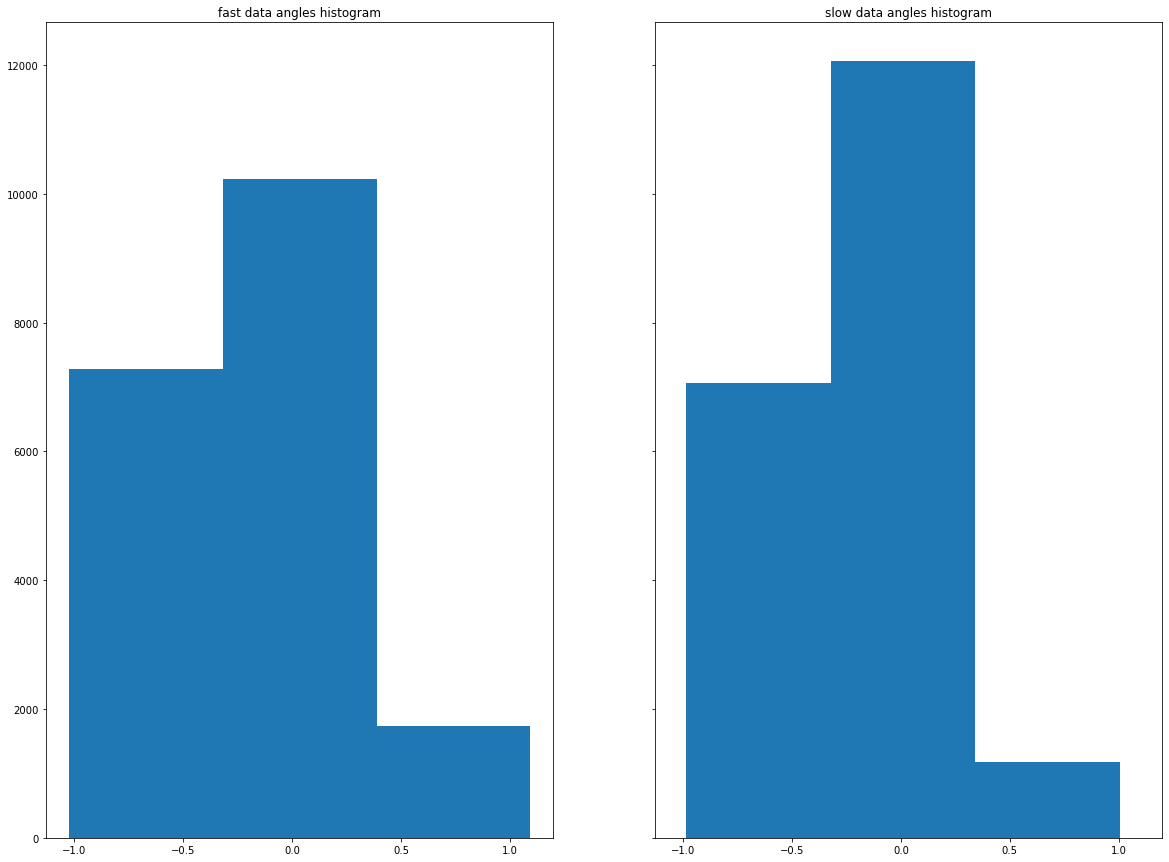

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15), sharex='all', sharey='all')

axs.flat[0].hist(fast_gt, bins=3)
axs.flat[0].set_title('fast data angles histogram')
axs.flat[1].hist(slow_gt, bins=3)
axs.flat[1].set_title('slow data angles histogram')


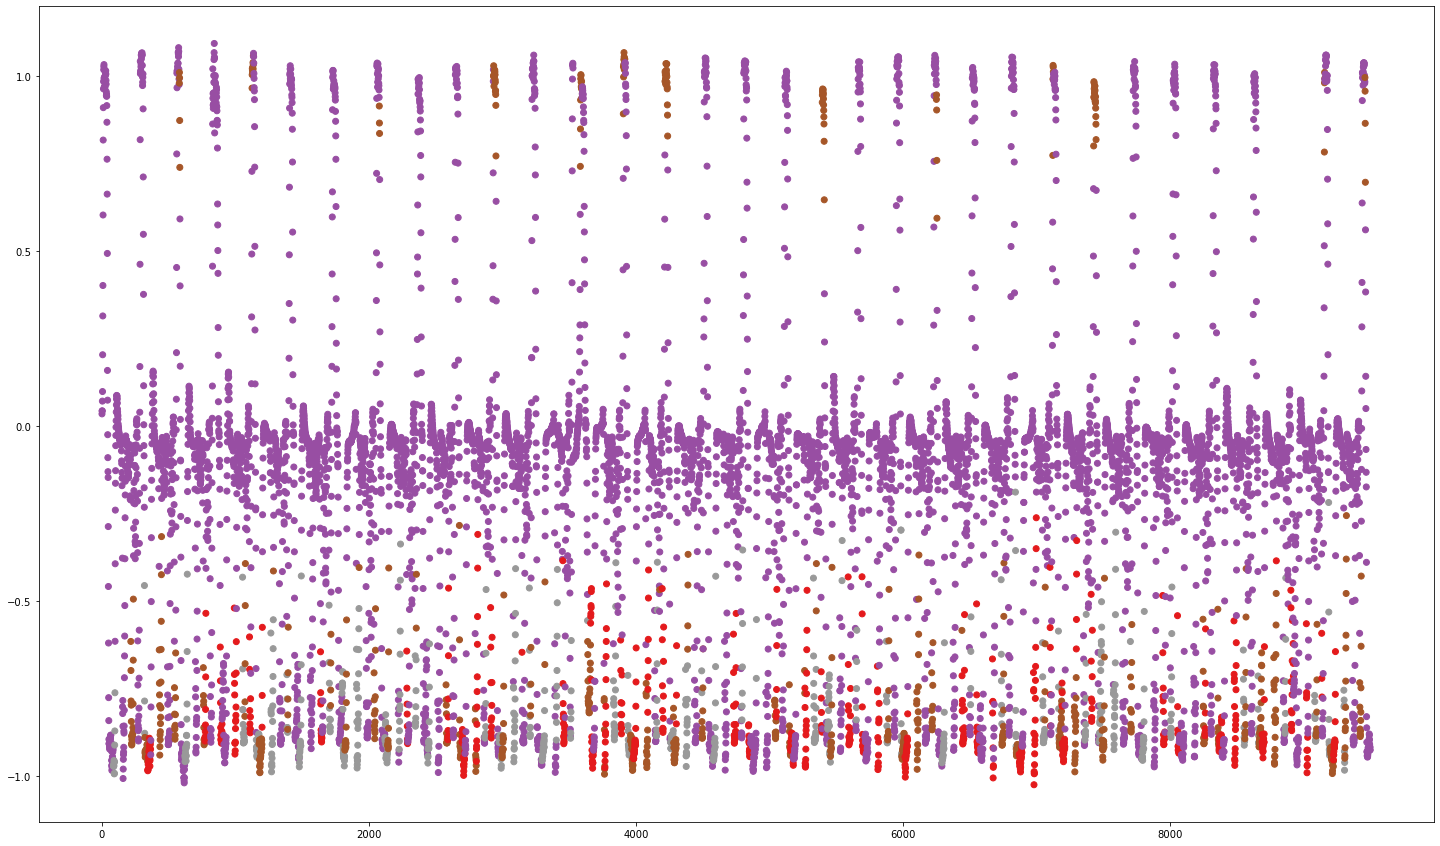

In [19]:
from matplotlib.pyplot import figure

figure(figsize=(25, 15))

plt.scatter(range(len(train_labels)), fast_gt[:len(train_labels)], c=train_labels, cmap='Set1')


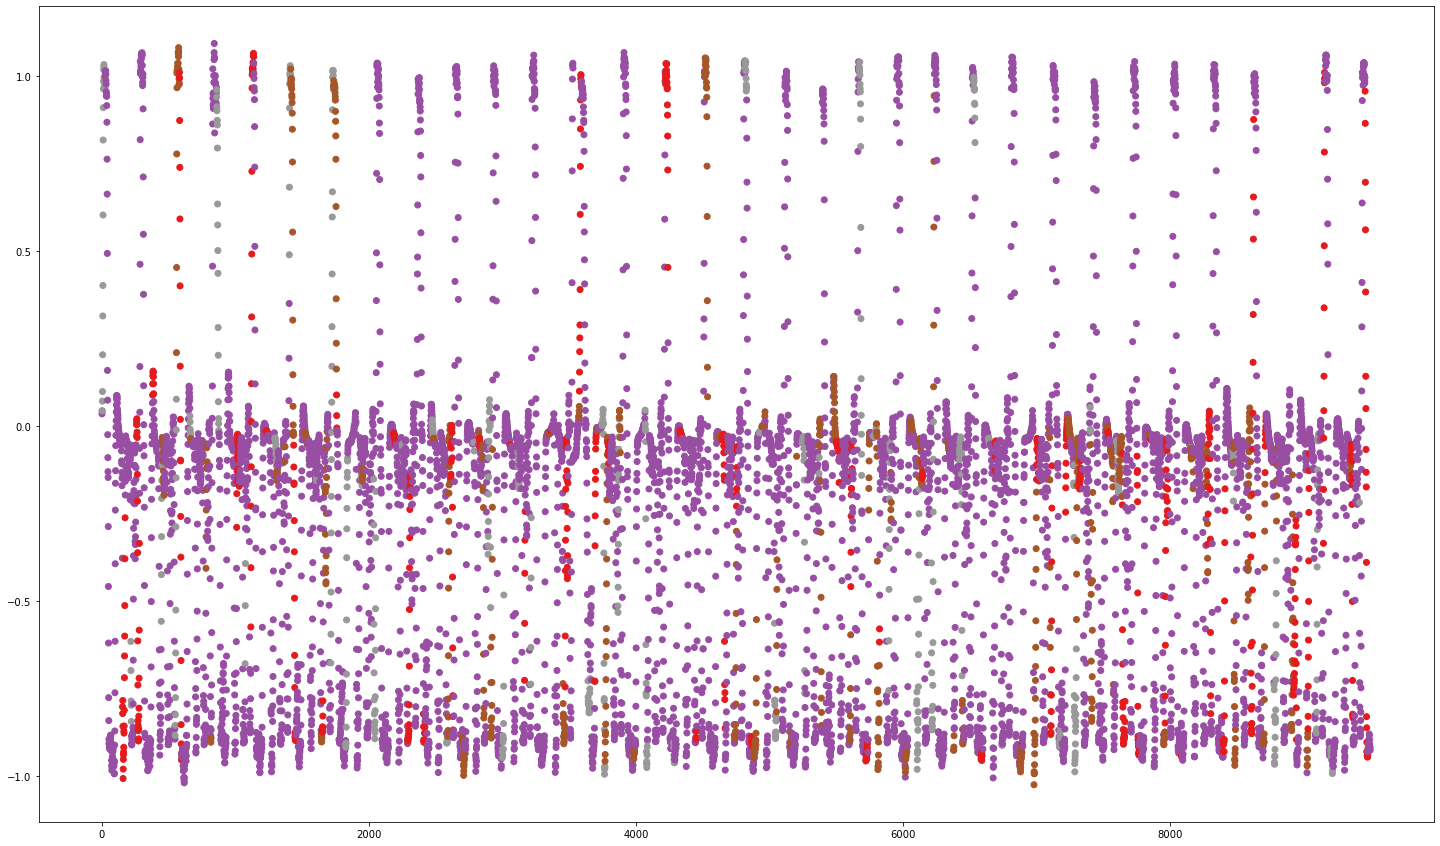

In [20]:
from matplotlib.pyplot import figure

figure(figsize=(25, 15))

plt.scatter(range(len(test_labels)), fast_gt[:len(test_labels)], c=test_labels, cmap='Set1')


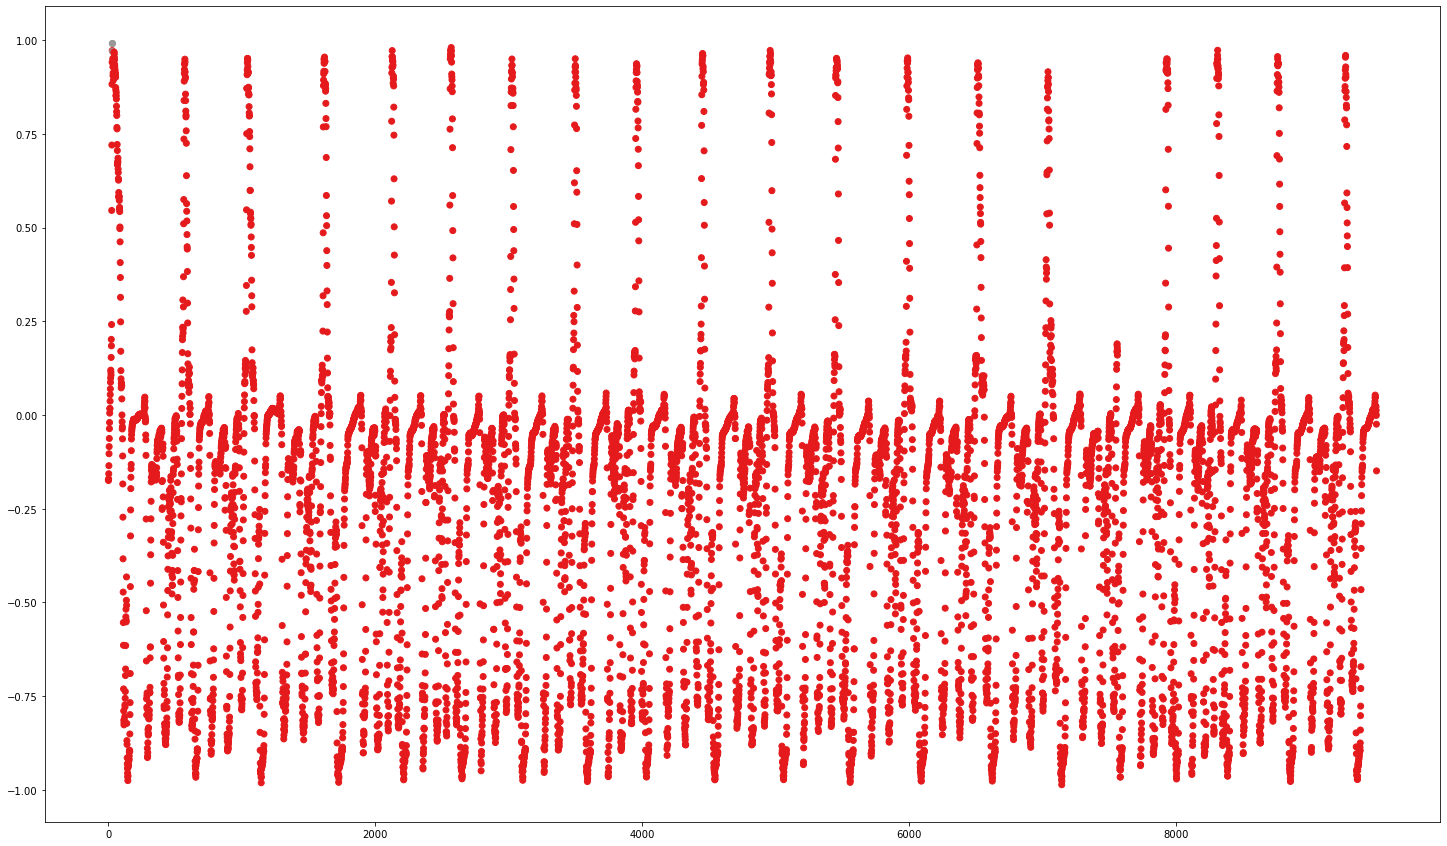

In [50]:
from matplotlib.pyplot import figure

figure(figsize=(25, 15))

plt.scatter(range(len(ood_labels)), slow_gt[:9500], c=ood_labels, cmap='Set1')


In [22]:
# assign angles to 3 classes

In [23]:

fast_clazz = np.zeros(len(fast_gt))

fast_clazz[fast_gt < -0.2] = -1
fast_clazz[fast_gt >= -0.2] = 0
fast_clazz[fast_gt > 0.2] = 1

slow_clazz = np.zeros(len(slow_gt))

slow_clazz[slow_gt < -0.2] = -1
slow_clazz[slow_gt >= -0.2] = 0
slow_clazz[slow_gt > 0.2] = 1


In [24]:
import pandas as pd

df = pd.DataFrame(np.array([fast_clazz[:9500],
                            train_labels,
                            np.ones(9500)
                            ]).T,
                  columns=['angle_class', 'train', 'a'])

class_cluster_count = df.groupby(['angle_class', 'train']).count()
class_cluster_count['a'] / class_cluster_count.groupby('train')['a'].transform('sum') * 100


angle_class  train
-1.0         0.0      100.000000
             1.0       26.430034
             2.0       82.788945
             3.0       99.855282
 0.0         1.0       62.716724
             3.0        0.144718
 1.0         1.0       10.853242
             2.0       17.211055
Name: a, dtype: float64

In [25]:
df = pd.DataFrame(np.array([fast_clazz[9500:9500+9500],
                            test_labels,
                            np.ones(9500)
                            ]).T,
                  columns=['angle_class', 'test', 'a'])

class_cluster_count = df.groupby(['angle_class', 'test']).count()
class_cluster_count['a'] / class_cluster_count.groupby('test')['a'].transform('sum') * 100

angle_class  test
-1.0         0.0     100.000000
             1.0      25.048652
             2.0      84.193548
             3.0     100.000000
 0.0         1.0      64.498193
 1.0         1.0      10.453155
             2.0      15.806452
Name: a, dtype: float64

In [51]:
df = pd.DataFrame(np.array([slow_clazz[:9500],
                            ood_labels,
                            np.ones(9500)
                            ]).T,
                  columns=['angle_class', 'ood', 'a'])

class_cluster_count = df.groupby(['angle_class', 'ood']).count()
class_cluster_count['a'] / class_cluster_count.groupby('ood')['a'].transform('sum') * 100


angle_class  ood
-1.0         1.0     41.444667
 0.0         1.0     51.974308
 1.0         1.0      6.581026
             3.0    100.000000
Name: a, dtype: float64

In [ ]:
# TSNE

In [77]:
from sklearn.manifold import TSNE
low_dim_train = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(train)


/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [78]:
low_dim_train.embedding_.shape

(9500, 3)

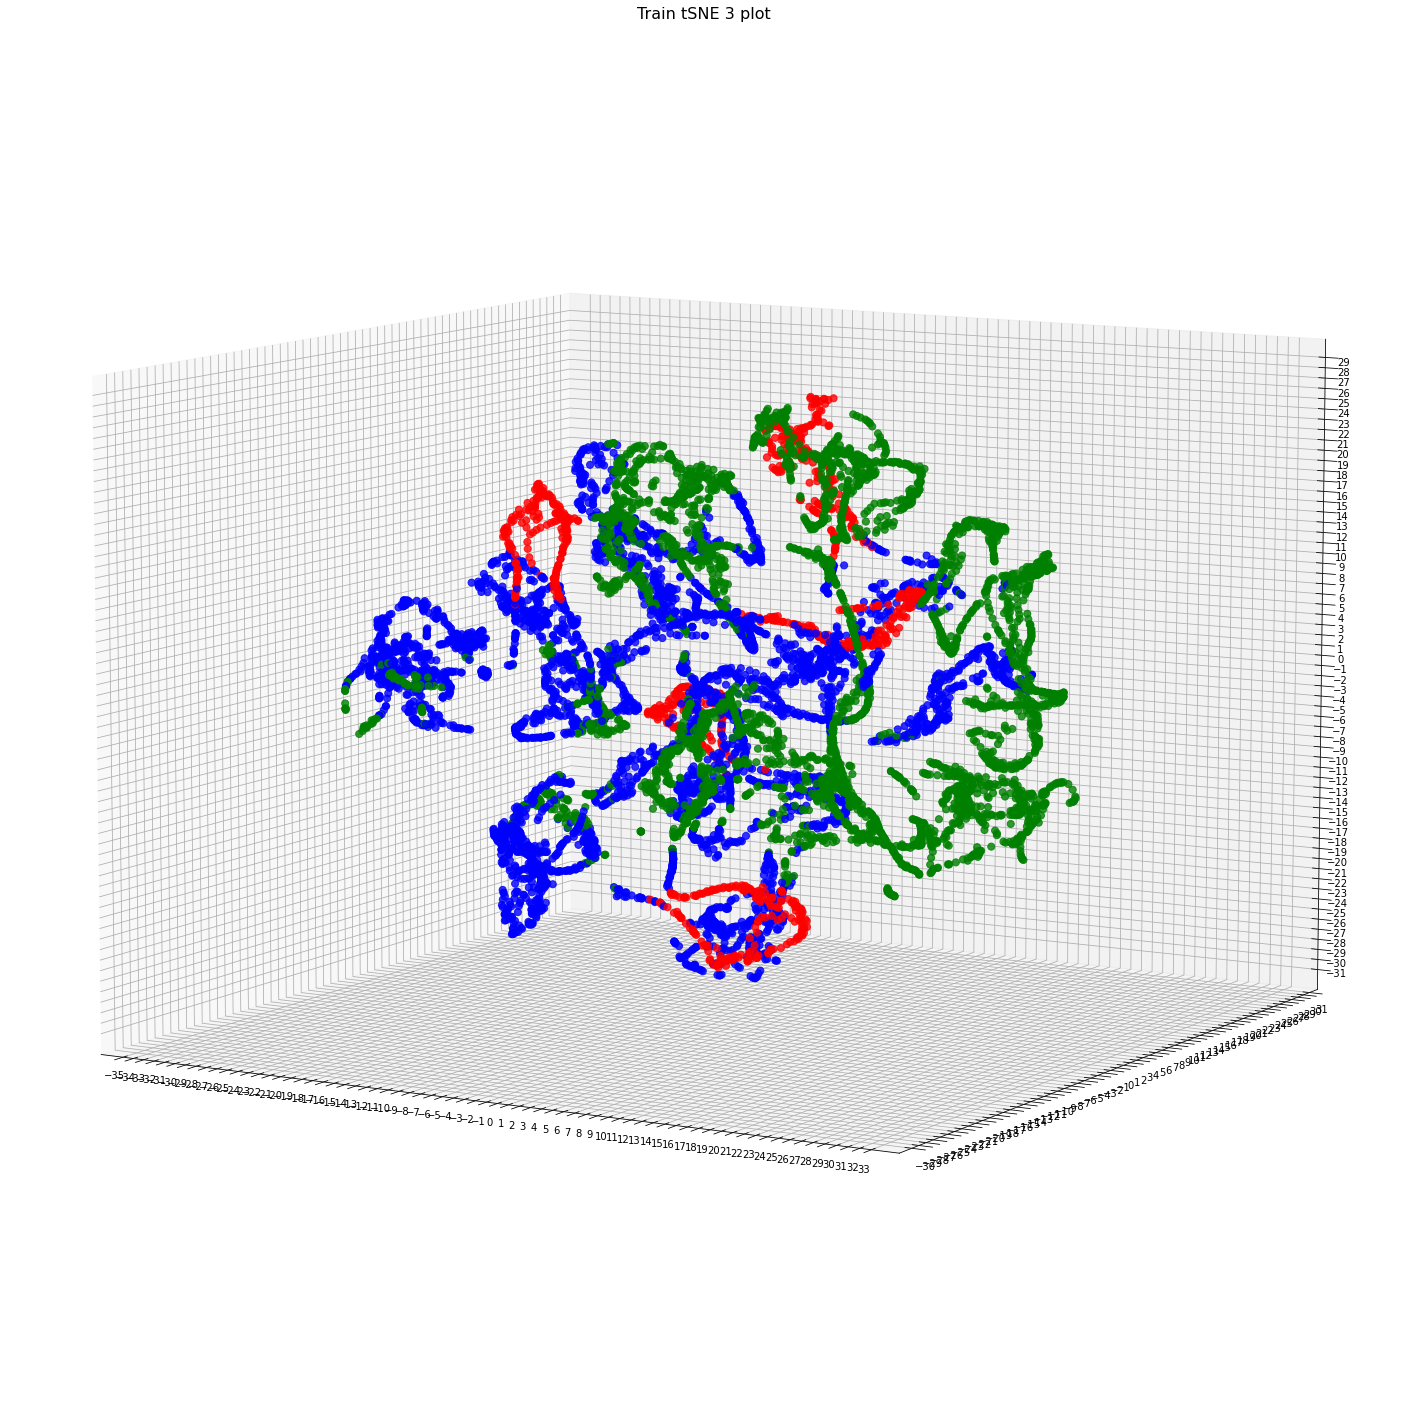

In [79]:
from matplotlib import ticker
import matplotlib

def plot_3d(points, points_color, title):

    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(20, 20),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8, cmap=matplotlib.colors.ListedColormap(['green', 'blue', 'red']))
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

plot_3d(low_dim_train.embedding_, fast_clazz[:9500], 'Train tSNE 3 plot')

In [80]:
low_dim_test = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(test)

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


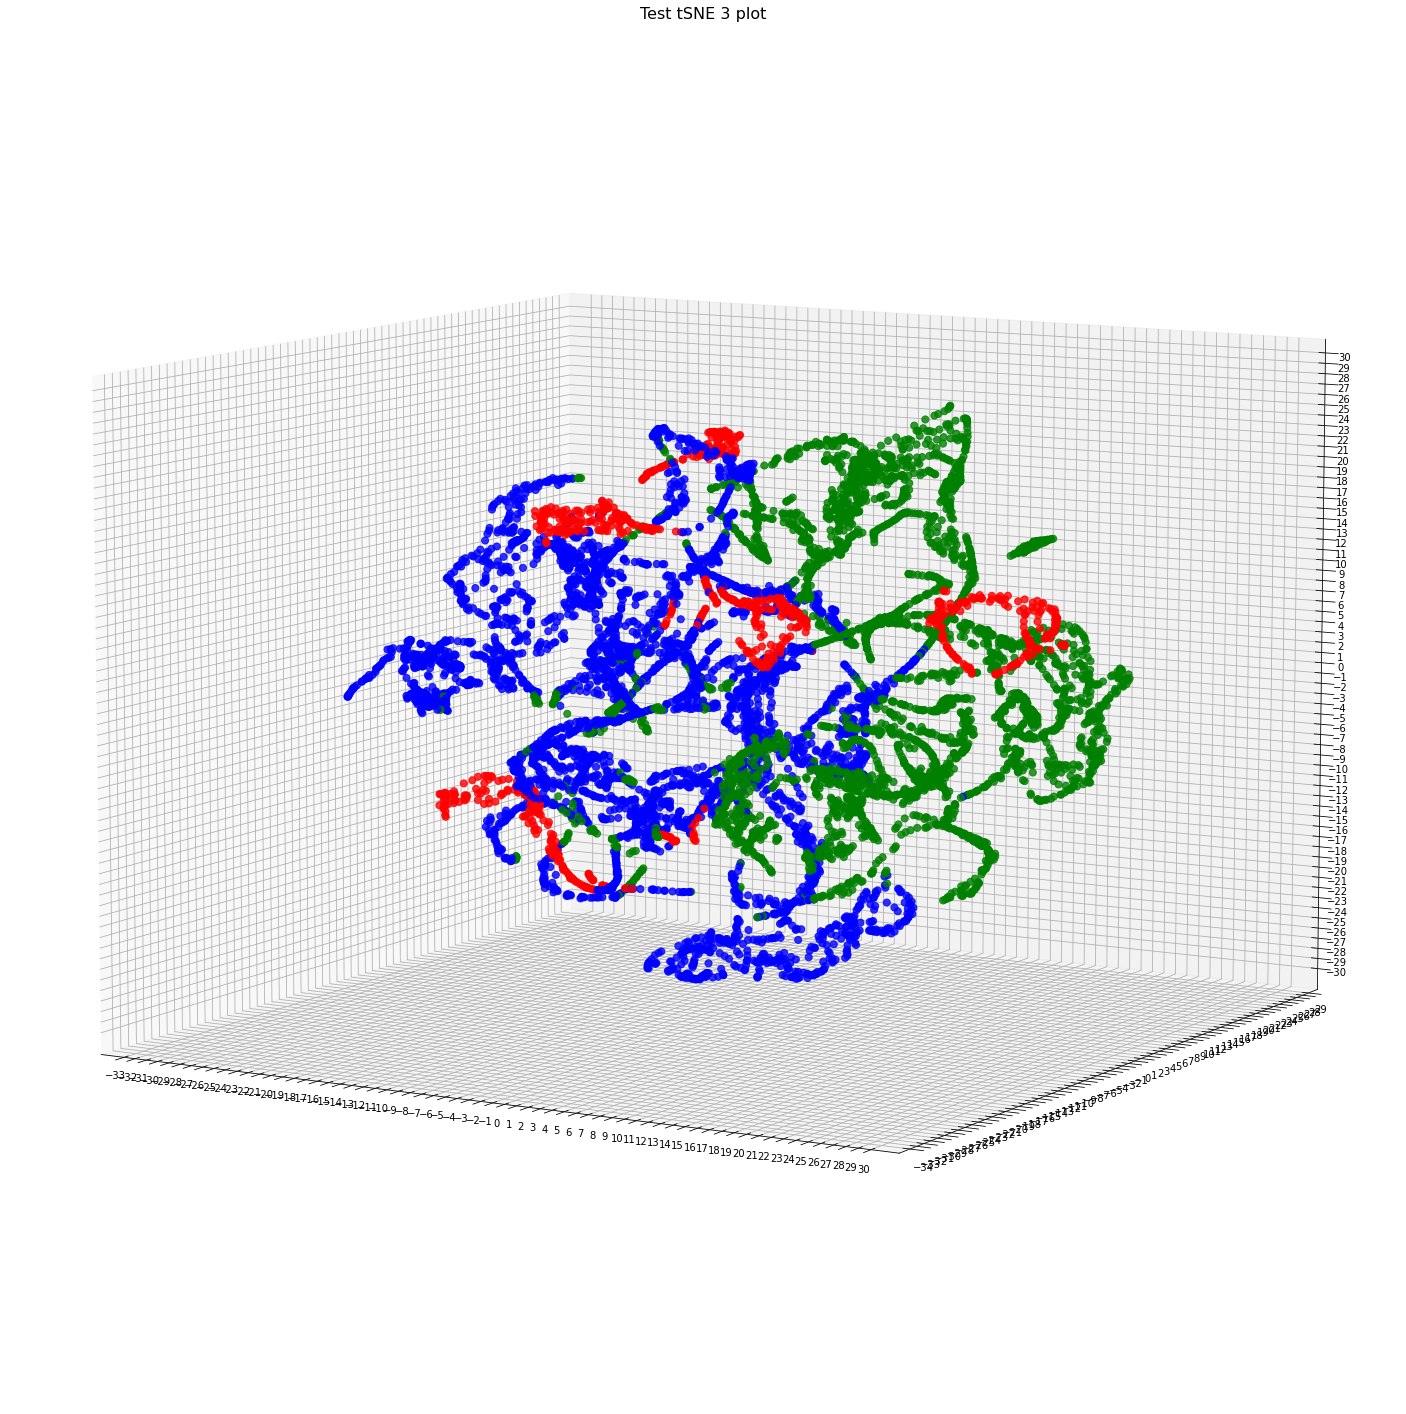

In [81]:
plot_3d(low_dim_test.embedding_, fast_clazz[9500:9500+9500], 'Test tSNE 3 plot')

In [82]:
low_dim_ood = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(ood_data)

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


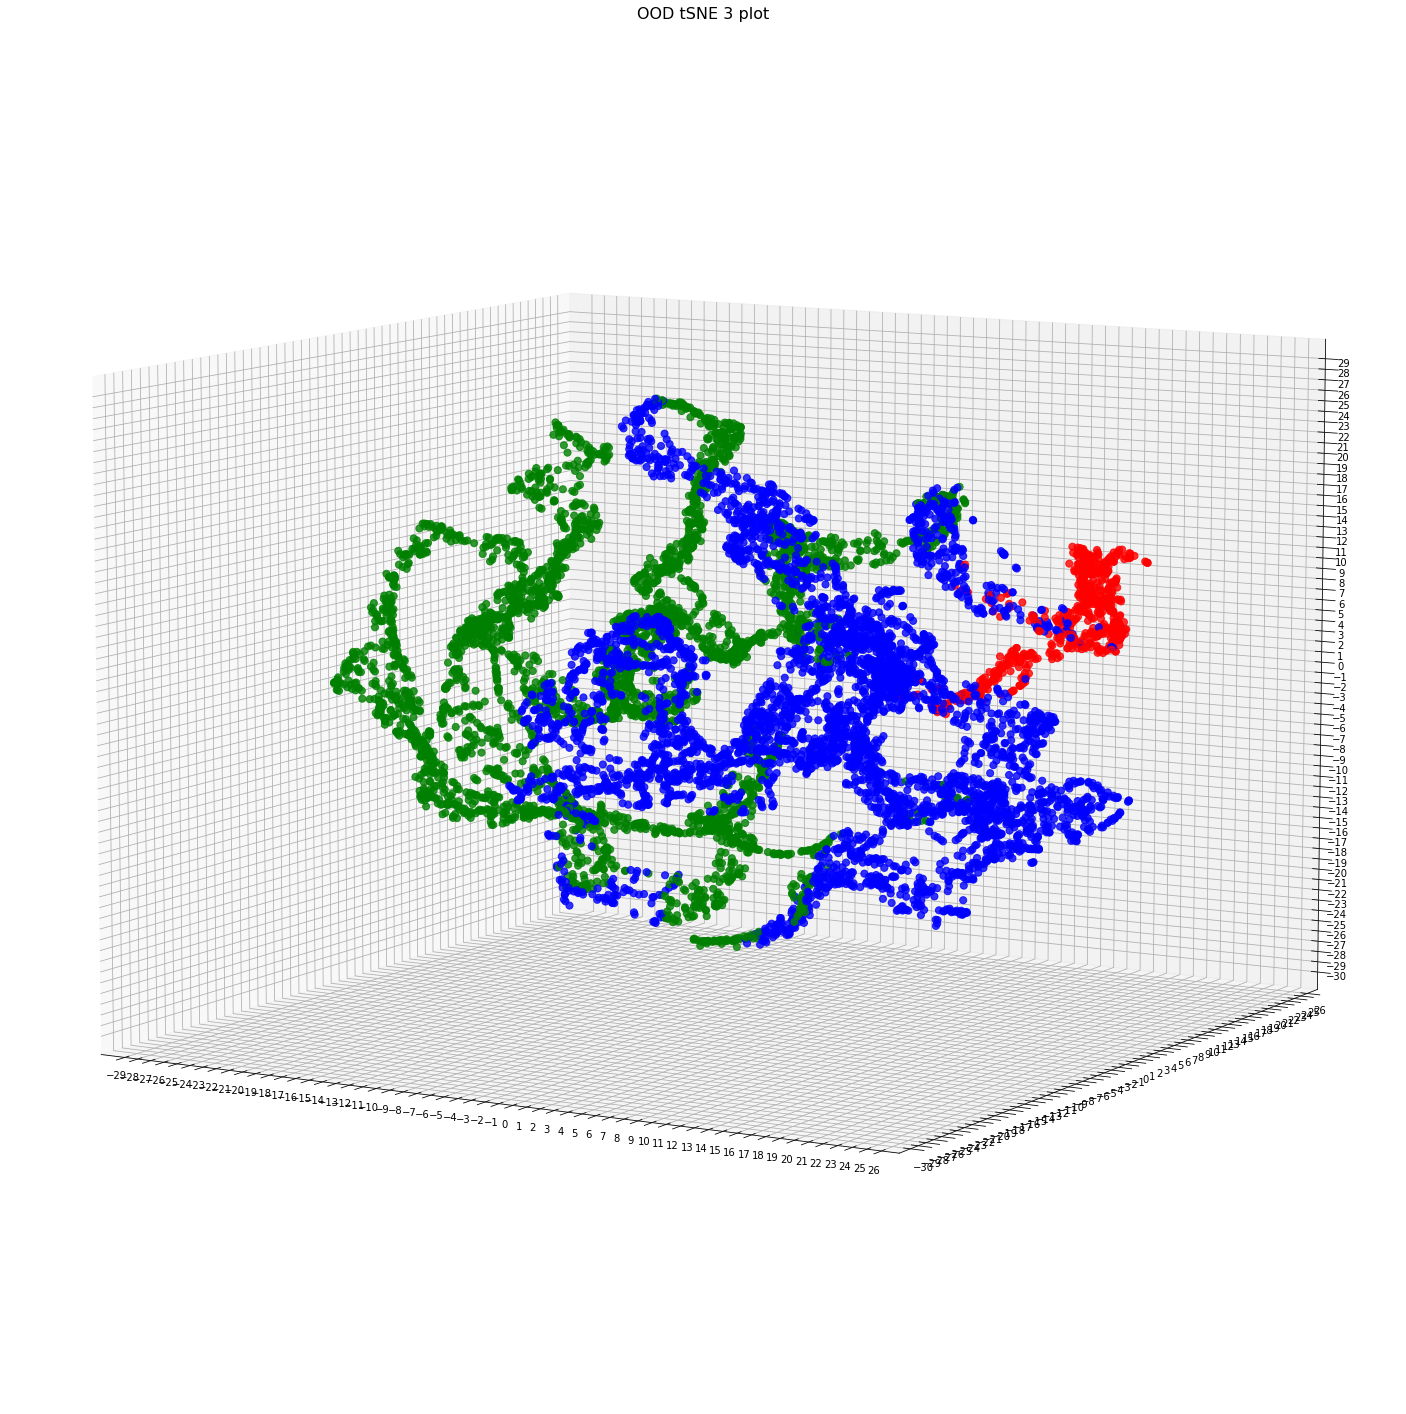

In [83]:

plot_3d(low_dim_ood.embedding_, slow_clazz[:9500], 'OOD tSNE 3 plot')